# Simple GP Regression
Source: https://docs.gpytorch.ai/en/latest/examples/01_Exact_GPs/Simple_GP_Regression.html

In [1]:
import math
import torch
import gpytorch as gpt
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [3]:
train_x.shape, train_y.shape

(torch.Size([100]), torch.Size([100]))

### Setting up the model

In [4]:
from IPython.core.debugger import set_trace

In [5]:
# A basic GP model with exact inference

class ExactGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.ConstantMean()
        self.covar_module = gpt.kernels.ScaleKernel(gpt.kernels.RBFKernel())
        
    def forward(self, x):
        #set_trace()
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultivariateNormal(mean_x, covar_x)
    
# Initialize likelihood and model
likelihood = gpt.likelihoods.GaussianLikelihood(
    noise_constraint=gpt.constraints.GreaterThan(1e-2),
)
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
model.mean_module, model.covar_module

(ConstantMean(),
 ScaleKernel(
   (base_kernel): RBFKernel(
     (raw_lengthscale_constraint): Positive()
   )
   (raw_outputscale_constraint): Positive()
 ))

In [7]:
# View model hyper parameters
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = 0.0
Parameter name: mean_module.constant                       value = 0.0
Parameter name: covar_module.raw_outputscale               value = 0.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = 0.0


In [8]:
# Initializing hyperparameters in One Call
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(1.),
    'covar_module.base_kernel.lengthscale': torch.tensor(0.5),
    'covar_module.outputscale': torch.tensor(2.),
}

model.initialize(**hypers)
print(
    model.likelihood.noise_covar.noise.item(),
    model.covar_module.base_kernel.lengthscale.item(),
    model.covar_module.outputscale.item()
)

1.0 0.5 2.0


### Training the model

In [9]:
training_iter = 50

# Find optimal model hyperparameters
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - The marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    optimizer.zero_grad()
    output = model(train_x)
    
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 1.057   lengthscale: 0.500   noise: 1.000
Iter 2/50 - Loss: 1.021   lengthscale: 0.462   noise: 0.938
Iter 3/50 - Loss: 0.983   lengthscale: 0.426   noise: 0.879
Iter 4/50 - Loss: 0.946   lengthscale: 0.392   noise: 0.822
Iter 5/50 - Loss: 0.910   lengthscale: 0.361   noise: 0.767
Iter 6/50 - Loss: 0.875   lengthscale: 0.334   noise: 0.715
Iter 7/50 - Loss: 0.842   lengthscale: 0.310   noise: 0.665
Iter 8/50 - Loss: 0.810   lengthscale: 0.290   noise: 0.618
Iter 9/50 - Loss: 0.778   lengthscale: 0.275   noise: 0.573
Iter 10/50 - Loss: 0.745   lengthscale: 0.263   noise: 0.531
Iter 11/50 - Loss: 0.712   lengthscale: 0.255   noise: 0.491
Iter 12/50 - Loss: 0.677   lengthscale: 0.251   noise: 0.453
Iter 13/50 - Loss: 0.642   lengthscale: 0.249   noise: 0.418
Iter 14/50 - Loss: 0.607   lengthscale: 0.250   noise: 0.385
Iter 15/50 - Loss: 0.571   lengthscale: 0.253   noise: 0.354
Iter 16/50 - Loss: 0.534   lengthscale: 0.257   noise: 0.325
Iter 17/50 - Loss: 0.497   length

/home/danh/WORK/codes/oss/temp/gpytorch/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 34/50 - Loss: 0.022   lengthscale: 0.267   noise: 0.071
Iter 35/50 - Loss: 0.009   lengthscale: 0.266   noise: 0.066
Iter 36/50 - Loss: -0.002   lengthscale: 0.266   noise: 0.062
Iter 37/50 - Loss: -0.012   lengthscale: 0.267   noise: 0.058
Iter 38/50 - Loss: -0.019   lengthscale: 0.269   noise: 0.054
Iter 39/50 - Loss: -0.025   lengthscale: 0.272   noise: 0.051
Iter 40/50 - Loss: -0.030   lengthscale: 0.275   noise: 0.049
Iter 41/50 - Loss: -0.032   lengthscale: 0.278   noise: 0.046
Iter 42/50 - Loss: -0.034   lengthscale: 0.280   noise: 0.044
Iter 43/50 - Loss: -0.035   lengthscale: 0.281   noise: 0.042
Iter 44/50 - Loss: -0.035   lengthscale: 0.281   noise: 0.041
Iter 45/50 - Loss: -0.034   lengthscale: 0.280   noise: 0.040
Iter 46/50 - Loss: -0.034   lengthscale: 0.278   noise: 0.038
Iter 47/50 - Loss: -0.032   lengthscale: 0.275   noise: 0.037
Iter 48/50 - Loss: -0.031   lengthscale: 0.273   noise: 0.037
Iter 49/50 - Loss: -0.030   lengthscale: 0.271   noise: 0.036
Iter 50/50

In [10]:
# View model hyper parameters after training
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.item()}')

Parameter name: likelihood.noise_covar.raw_noise           value = -3.68184494972229
Parameter name: mean_module.constant                       value = -0.10513433814048767
Parameter name: covar_module.raw_outputscale               value = 0.29086971282958984
Parameter name: covar_module.base_kernel.raw_lengthscale   value = -1.1709681749343872


In [11]:
# Getting Model State
model.state_dict()

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-3.6818])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(0.0100)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.constant', tensor([-0.1051])),
             ('covar_module.raw_outputscale', tensor(0.2909)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-1.1710]])),
             ('covar_module.base_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale_constraint.upper_bound',
              tensor(inf)),
             ('covar_module.raw_outputscale_constraint.lower_bound',
              tensor(0.)),
             ('covar_module.raw_outputscale_constraint.upper_bound',
              tensor(inf))])

### Make predictions with the model

In [12]:
# Get into evaluation - posterior predictive - mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpt.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

In [13]:
with torch.no_grad():
    f_preds = model(test_x)

### Plot the model fit

In [14]:
observed_pred

MultivariateNormal(loc: torch.Size([51]))

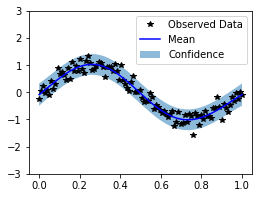

In [15]:
with torch.no_grad():
    f, ax = plt.subplots(1,1,figsize=(4,3))
    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3,3])
    ax.legend(["Observed Data", "Mean", "Confidence"])

In [18]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sun Sep 04 2022

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

torch     : 1.11.0
gpytorch  : 1.8.0
matplotlib: 3.5.2

Watermark: 2.3.1

